In [1]:
%cd ..

import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import pennylane as qml

from src.nn.ansatz.simplified_two_design import simplified_two_design, get_num_params_simplified_two_design
from src.nn.ansatz.one_kernel import one_kernel, get_num_params_one_kernel
from src.nn.ansatz.two_kernels import two_kernels, get_num_params_two_kernels
from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.measurements.default import default_measurement
from src.nn.measurements.multiqubit_observable_measurement import get_pauli_multiqubit_observables,get_pauli_words,random_pauli_string_over_meas_wires,measurement_multiqubit
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.NQE_embedding import NQE_embedding
from src.nn.encodings.ring_embedding import ring_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding, QAOA_embedding
from src.nn.encodings.frqi_mc import FRQI_MC
from src.utils.dataset import EuroSAT, DeepSatCSV
from src.utils.reshape_data import ReshapeDATA

from src.nn.models.quantum.QCNN import QuantumCircuitModel
from src.utils.training import Trainer

import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

c:\Users\rodriguezota\FUJITSU\CoE Data Intelligence - CESGA- CIDE\Quantum_Center\Proyectos\Eurecat\src\QML-Satellite-Image-Classification


c:\Users\rodriguezota\FUJITSU\CoE Data Intelligence - CESGA- CIDE\Quantum_Center\Proyectos\Eurecat\src\venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
limit = 100
dataset_ = "EuroSAT"

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']
    
config = {
    'allowed_classes': ['Industrial', 'SeaLake']
    #'allowed_classes': ['Trees', 'Grassland', 'Other']
    #'allowed_classes': ['BarrenLand', 'Grassland', 'Buildings']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
n_classes = len(allowed_classes)

image_size = 16
batch_size = 16

In [3]:
if dataset_ == "EuroSAT":

    output = 'dl'
    data = EuroSAT(root= 'dataset/EuroSAT_RGB',
                            image_size=image_size,
                            examples_per_class=limit,
                            batch_size=batch_size,
                            allowed_classes=allowed_classes,
                            output = output
                     )
    
    if output == 'dl':
        train_loader, val_loader = data.get_loaders()
    else:
        X_train, y_train, X_val, y_val, index_mapping = data.get_loaders()
    
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)
    
        train_dataset = TensorDataset(X_train, y_train) 
        val_dataset = TensorDataset(X_val, y_val)
    
        train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
else:
    if dataset_ == "DeepSat4":
        # Root
        data_path = "dataset/DeepSat4/"
        x_train_file = data_path + "X_train_sat4.csv"
        y_train_file = data_path + "y_train_sat4.csv"
        x_test_file = data_path + "X_test_sat4.csv"
        y_test_file = data_path + "y_test_sat4.csv"
        
    elif dataset_ == "DeepSat6":
        # Root
        data_path = "dataset/DeepSat6/"
        x_train_file = data_path + "X_train_sat6.csv"
        y_train_file = data_path + "y_train_sat6.csv"
        x_test_file = data_path + "X_test_sat6.csv"
        y_test_file = data_path + "y_test_sat6.csv"
        
    # Limit
    max_train_samples = limit 
    max_test_samples = int(0.2 * limit)   
    
    # Create DataLoaders
    train_dataset = DeepSatCSV(x_train_file, y_train_file, max_samples=max_train_samples)
    test_dataset = DeepSatCSV(x_test_file, y_test_file, max_samples=max_test_samples)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

In [4]:
np.ceil(len(train_loader.dataset) / batch_size)

np.float64(10.0)

In [5]:
embedding = {
    'name': 'amplitude',
    'func': amplitude_embedding,
    'func_params': {
        'img_pixels': image_size
    }
}

# embedding = {
#     'name': 'FRQI_MC',
#     'func': FRQI_MC,
#     'func_params': {
#         'img_pixels': image_size
#     }
# }

if embedding['name'] == "FRQI_MC":
    n_wires = np.ceil(np.log2(image_size**2)+3).astype(int)
else:
    n_wires = np.ceil(np.log2(3*image_size**2)).astype(int)

use_quantum = True
log = False #graph accuracies in wandb
plot = True #plot confusion matrix
name_run = "Fully_connected"

learning_rate = 0.01
epochs = 5

print(dataset_)

EuroSAT


In [6]:
ansatz = {
    'name': 'simplified_two_design'
    # 'name': 'one_kernel'
    # 'name': 'two_kernels'
}

if ansatz['name'] == 'one_kernel':
    ansatz['func'] = one_kernel
    ansatz['func_params'] = {'layers':1}
    weight_shapes,_ = get_num_params_one_kernel(range(n_wires),ansatz['func_params'])
    
elif ansatz['name'] == 'two_kernels':
    ansatz['func'] = two_kernels
    ansatz['func_params'] = {'layers':1}
    weight_shapes,_ = get_num_params_two_kernels(range(n_wires),ansatz['func_params'])
    
elif ansatz['name'] == 'simplified_two_design':
    ansatz['func'] = simplified_two_design
    ansatz['func_params'] = {'layers':15}
    weight_shapes,_ = get_num_params_simplified_two_design(range(n_wires),ansatz['func_params'])


In [7]:
params_obs = {
    'meas_wires': range(n_wires),
    'n_obs': len(allowed_classes)
}

#observables = random_pauli_string_over_meas_wires(range(n_wires),params_obs)
observables = get_pauli_multiqubit_observables(range(n_wires),params_obs)

# measurement = {
#     'name': 'default',
#     'func': default_measurement,
#     'func_params': {
#         'observable': qml.PauliZ,
#         'meas_wires': params_obs['meas_wires']
#     }
# }

measurement = {
    'name': 'multiqubit',
    'func': measurement_multiqubit,
    'func_params': {
        'observables': observables
    }
}


In [8]:
observables

[Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4), Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9)]

In [9]:
from src.utils.reshape_data import ReshapeDATA

In [10]:
weight_shapes

280

In [11]:
model_qcnn = QuantumCircuitModel(n_wires=n_wires,
                     embedding=embedding,
                     circuit=ansatz,
                     measurement=measurement,
                     weight_shapes={'weights':weight_shapes},
                     reshaper=ReshapeDATA(wires=range(n_wires),params={'structure':'flat','img_pixels':image_size}))

## Fit model

In [12]:
name_prueba = f"Pruebas QCNN"

trainer_qcnn = Trainer(model = model_qcnn,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  log = log,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = True)
trainer_qcnn.device = 'cpu'


2025-03-12 21:02:13.650 | DEBUG    | src.utils.training:fit:226 - Epoch [1/5]: Train Loss = 0.6791, Train Acc = 65.00%, Val Loss = 0.6650, Val Acc = 55.00%
2025-03-12 21:03:07.320 | DEBUG    | src.utils.training:fit:226 - Epoch [2/5]: Train Loss = 0.6555, Train Acc = 72.50%, Val Loss = 0.6465, Val Acc = 67.50%
2025-03-12 21:03:54.445 | DEBUG    | src.utils.training:fit:226 - Epoch [3/5]: Train Loss = 0.6400, Train Acc = 67.50%, Val Loss = 0.6324, Val Acc = 70.00%
2025-03-12 21:04:41.490 | DEBUG    | src.utils.training:fit:226 - Epoch [4/5]: Train Loss = 0.6292, Train Acc = 72.50%, Val Loss = 0.6243, Val Acc = 77.50%
2025-03-12 21:05:33.176 | DEBUG    | src.utils.training:fit:226 - Epoch [5/5]: Train Loss = 0.6198, Train Acc = 76.88%, Val Loss = 0.6180, Val Acc = 77.50%


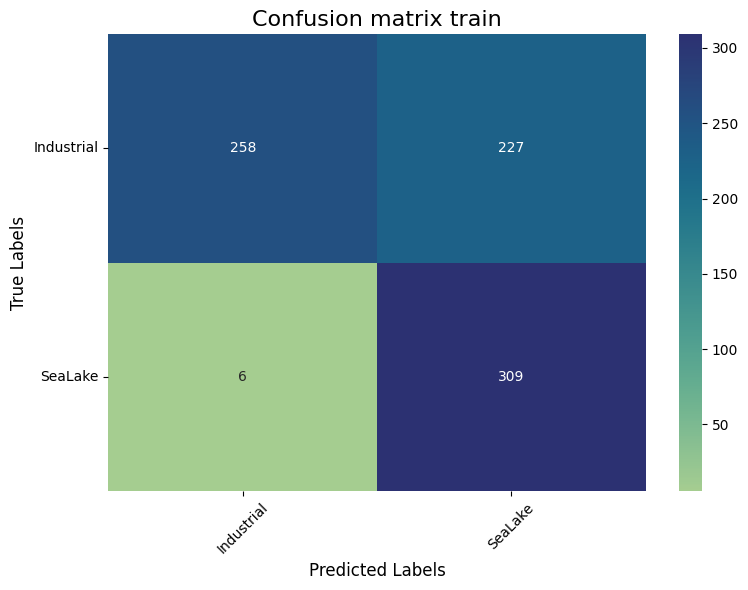

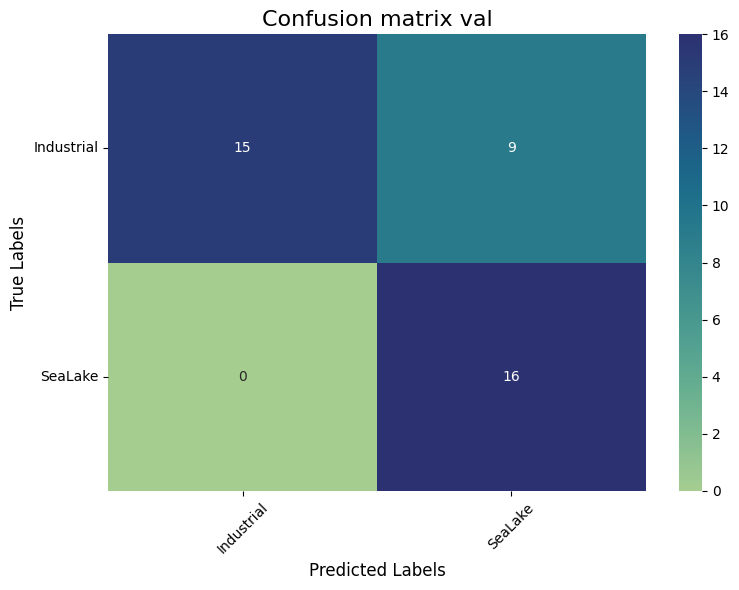

Tiempo de entrenamiento: 4 minutos y 26 segundos


In [13]:
t0 = time.time()
trainer_qcnn.fit()
t1 = (time.time()-t0)/60
print(f"Tiempo de entrenamiento: {int(t1)} minutos y {int(np.round((t1-int(t1))*60,0))} segundos")
